In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sopt
from pysimu import ode2numba, ssa

from ipywidgets import *
import numba

In [2]:
%matplotlib notebook

In [3]:
import vsg_pi_z
syst = vsg_pi_z.vsg_pi_z_class()
run = vsg_pi_z.run

## System definition 

In [4]:

x0 = np.ones(syst.N_x+syst.N_y)
x0[0] = 0
s = sopt.fsolve(syst.run_problem,x0 )
print(s)

[ 2.40497323e-02 -3.11549909e-16  6.22386867e-03 -1.44291562e-12
  1.00000000e+00  1.00000000e+00  4.00000000e-01 -4.90152704e-32
  4.00000000e-01  1.00000000e+00 -1.43665725e-12  3.98295839e-01
  1.08520816e-01  1.08520816e-01 -3.98295839e-01  9.89114481e-02
 -4.00790303e-01 -3.01878855e-03 -9.98773149e-01  2.10000001e-02
 -9.98556918e-01  2.10000001e-02  9.98556918e-01  6.27126860e-26
 -2.30989227e-25  4.00000000e-01  1.00000000e-01]


In [5]:
x = s
x[0] = 0
s = sopt.fsolve(syst.run_problem,x0 )
print(s)

[ 2.40497323e-02 -3.11549909e-16  6.22386867e-03 -1.44291562e-12
  1.00000000e+00  1.00000000e+00  4.00000000e-01 -4.90152704e-32
  4.00000000e-01  1.00000000e+00 -1.43665725e-12  3.98295839e-01
  1.08520816e-01  1.08520816e-01 -3.98295839e-01  9.89114481e-02
 -4.00790303e-01 -3.01878855e-03 -9.98773149e-01  2.10000001e-02
 -9.98556918e-01  2.10000001e-02  9.98556918e-01  6.27126860e-26
 -2.30989227e-25  4.00000000e-01  1.00000000e-01]


In [151]:

@numba.njit(cache=True) 
def perturbations(t,struct): 
    
    struct[0].RoCoFpu=0.0
    if t>1.0: struct[0].RoCoFpu= -1.0/50
    if t>6.0: struct[0].RoCoFpu= 0.0
    struct[0].p_m=0.4
    if t>0.5: struct[0].p_m= 0.8
    if t>9: struct[0].V_g= 0.95
    if t>8: struct[0].q_s_ref = 0.2
    #struct[0].p_m=0.8
    #if t>1.0: struct[0].p_m =0.9
    #if t>6.0: struct[0].p_m= 0.8
    return
    
@numba.njit(cache=True) 
def solver(struct): 
    sin = np.sin
    cos = np.cos
    sqrt = np.sqrt
    i = 0 
    
    Dt = struct[i].Dt 
    N_steps = struct[i].N_steps 
    N_store = struct[i].N_store 
    N_x = struct[i].N_x
    N_y = struct[i].N_y
    N_outs = 1 
    decimation = struct[i].decimation 
    eye = np.eye(N_x)
    # initialization 
    #t = struct[i].t 
    t = 0.0
    #run(0.0,struct, 1) 
    it_store = 0 
    struct[i]['T'][0] = t 
    struct[i].X[0,:] = struct[i].x[:,0]  
    
    Y = np.zeros((N_store,N_y))
    Y[0,:] = struct[i].y[:,0]  
 
    for it in range(N_steps-1): 
        t += Dt 
 
        perturbations(t,struct) 
        solver = struct[i].solvern 
        if solver == 1: 
            # forward euler solver  
            run(t,struct, 2)  
            struct[i].x[:] += Dt*struct[i].f  
 
        if solver == 2: 
            
            # bacward euler solver
            x_0 = np.copy(struct[i].x[:]) 
            for j in range(struct[i].imax): 
                run(t,struct, 2) 
                run(t,struct, 3) 
                run(t,struct, 10)  
                phi =  x_0 + Dt*struct[i].f - struct[i].x 
                Dx = np.linalg.solve(-(Dt*struct[i].Fx - np.eye(N_x)), phi) 
                struct[i].x[:] += Dx[:] 
                if np.max(np.abs(Dx)) < struct[i].itol: break 
            print(struct[i].f)
 
        if solver == 3: 
            # trapezoidal solver
            run(t,struct, 2) 
            f_0 = np.copy(struct[i].f[:]) 
            x_0 = np.copy(struct[i].x[:]) 
            for j in range(struct[i].imax): 
                run(t,struct, 10)  
                phi =  x_0 + 0.5*Dt*(f_0 + struct[i].f) - struct[i].x 
                Dx = np.linalg.solve(-(0.5*Dt*struct[i].Fx - np.eye(N_x)), phi) 
                struct[i].x[:] += Dx[:] 
                run(t,struct, 2) 
                if np.max(np.abs(Dx)) < struct[i].itol: break 

        if solver == 4: 
            #print(t)
            run(t,struct, 2) 
            run(t,struct, 3) 

            x = np.copy(struct[i].x[:]) 
            y = np.copy(struct[i].y[:]) 
            f = np.copy(struct[i].f[:]) 
            g = np.copy(struct[i].g[:]) 
            
            for iter in range(50):
                run(t,struct, 2) 
                run(t,struct, 3) 
                run(t,struct,10) 
                run(t,struct,11) 
                
                x_i = struct[i].x[:] 
                y_i = struct[i].y[:]  
                f_i = struct[i].f[:] 
                g_i = struct[i].g[:]                 
                F_x_i = struct[i].Fx[:,:]
                F_y_i = struct[i].Fy[:,:] 
                G_x_i = struct[i].Gx[:,:] 
                G_y_i = struct[i].Gy[:,:]                

                A_c_i = np.vstack((np.hstack((eye-0.5*Dt*F_x_i, -0.5*Dt*F_y_i)),
                                   np.hstack((G_x_i,         G_y_i))))
                     
                f_n_i = x_i - x - 0.5*Dt*(f_i+f) 
                
                Dxy_i = np.linalg.solve(-A_c_i,np.vstack((f_n_i,g_i))) 
                
                x_i = x_i + Dxy_i[0:N_x]
                y_i = y_i + Dxy_i[N_x:(N_x+N_y)]

                struct[i].x[:] = x_i
                struct[i].y[:] = y_i
                
                if np.max(np.abs(Dxy_i[:,0]))<1.0e-6:                   
                    break
   
        # channels 
        if it >= it_store*decimation: 
            struct[i]['T'][it_store+1] = t 
            struct[i].X[it_store+1,:] = struct[i].x[:,0] 
            Y[it_store+1,:] = struct[i].y[:,0]
            it_store += 1 
    struct[i].t = t
    return struct[i]['T'][:], struct[i].X[:], Y 

In [162]:
# considered bases
S_b, U_b = 20e3, 400.0


# CIGRE LV 240mm2 line (UG1):
Lenght = 0.003
Z_km = 0.287 + 1j*0.167 - (0.121 + 1j*0.110) # Omega/km
Z_b = U_b**2/S_b
Z_km_pu = Z_km/Z_b
Z_line_pu = Z_km_pu*Lenght

# CIGRE LV transformer:
Z_tr = 0.0032+1j*0.0128 # Omega/km
Z_tr_pu = Z_tr/Z_b

Z_g_pu = Z_line_pu + Z_tr_pu
    
def solution(x0):
    syst.solvern = 4

    syst.t_end = 10.0
    syst.Dt = 0.001
    syst.decimation = 1

    syst.update()
    syst.struct[0].R_g = Z_g_pu.real
    syst.struct[0].X_g=  Z_g_pu.imag
    syst.struct[0].p_m = 0.4
    syst.struct[0].K_f=  0.00
    syst.struct[0].K_q=  10
    syst.struct[0].K_p=  0.01
    syst.struct[0].K_i=  0.1
    syst.struct[0].K_s=  1.0
    syst.struct[0].R_s=  0.0
    syst.struct[0].X_s=  0.0
    #syst.struct[0].K_pll= 10
    #syst.struct[0].D=200


    s = sopt.fsolve(syst.run_problem,x0 )
    syst.struct[0].x[:,0] = s[0:syst.N_x]
    syst.struct[0].y[:,0] = s[syst.N_x:]
    x0 = s
    T,X,Y = solver(syst.struct)
    
    return T,X,Y,x0


In [163]:
x0 = np.ones((syst.N_x+syst.N_y,1))
x0[0] = 0

T,X,Y,x0 = solution(x0)

<IPython.core.display.Javascript object>


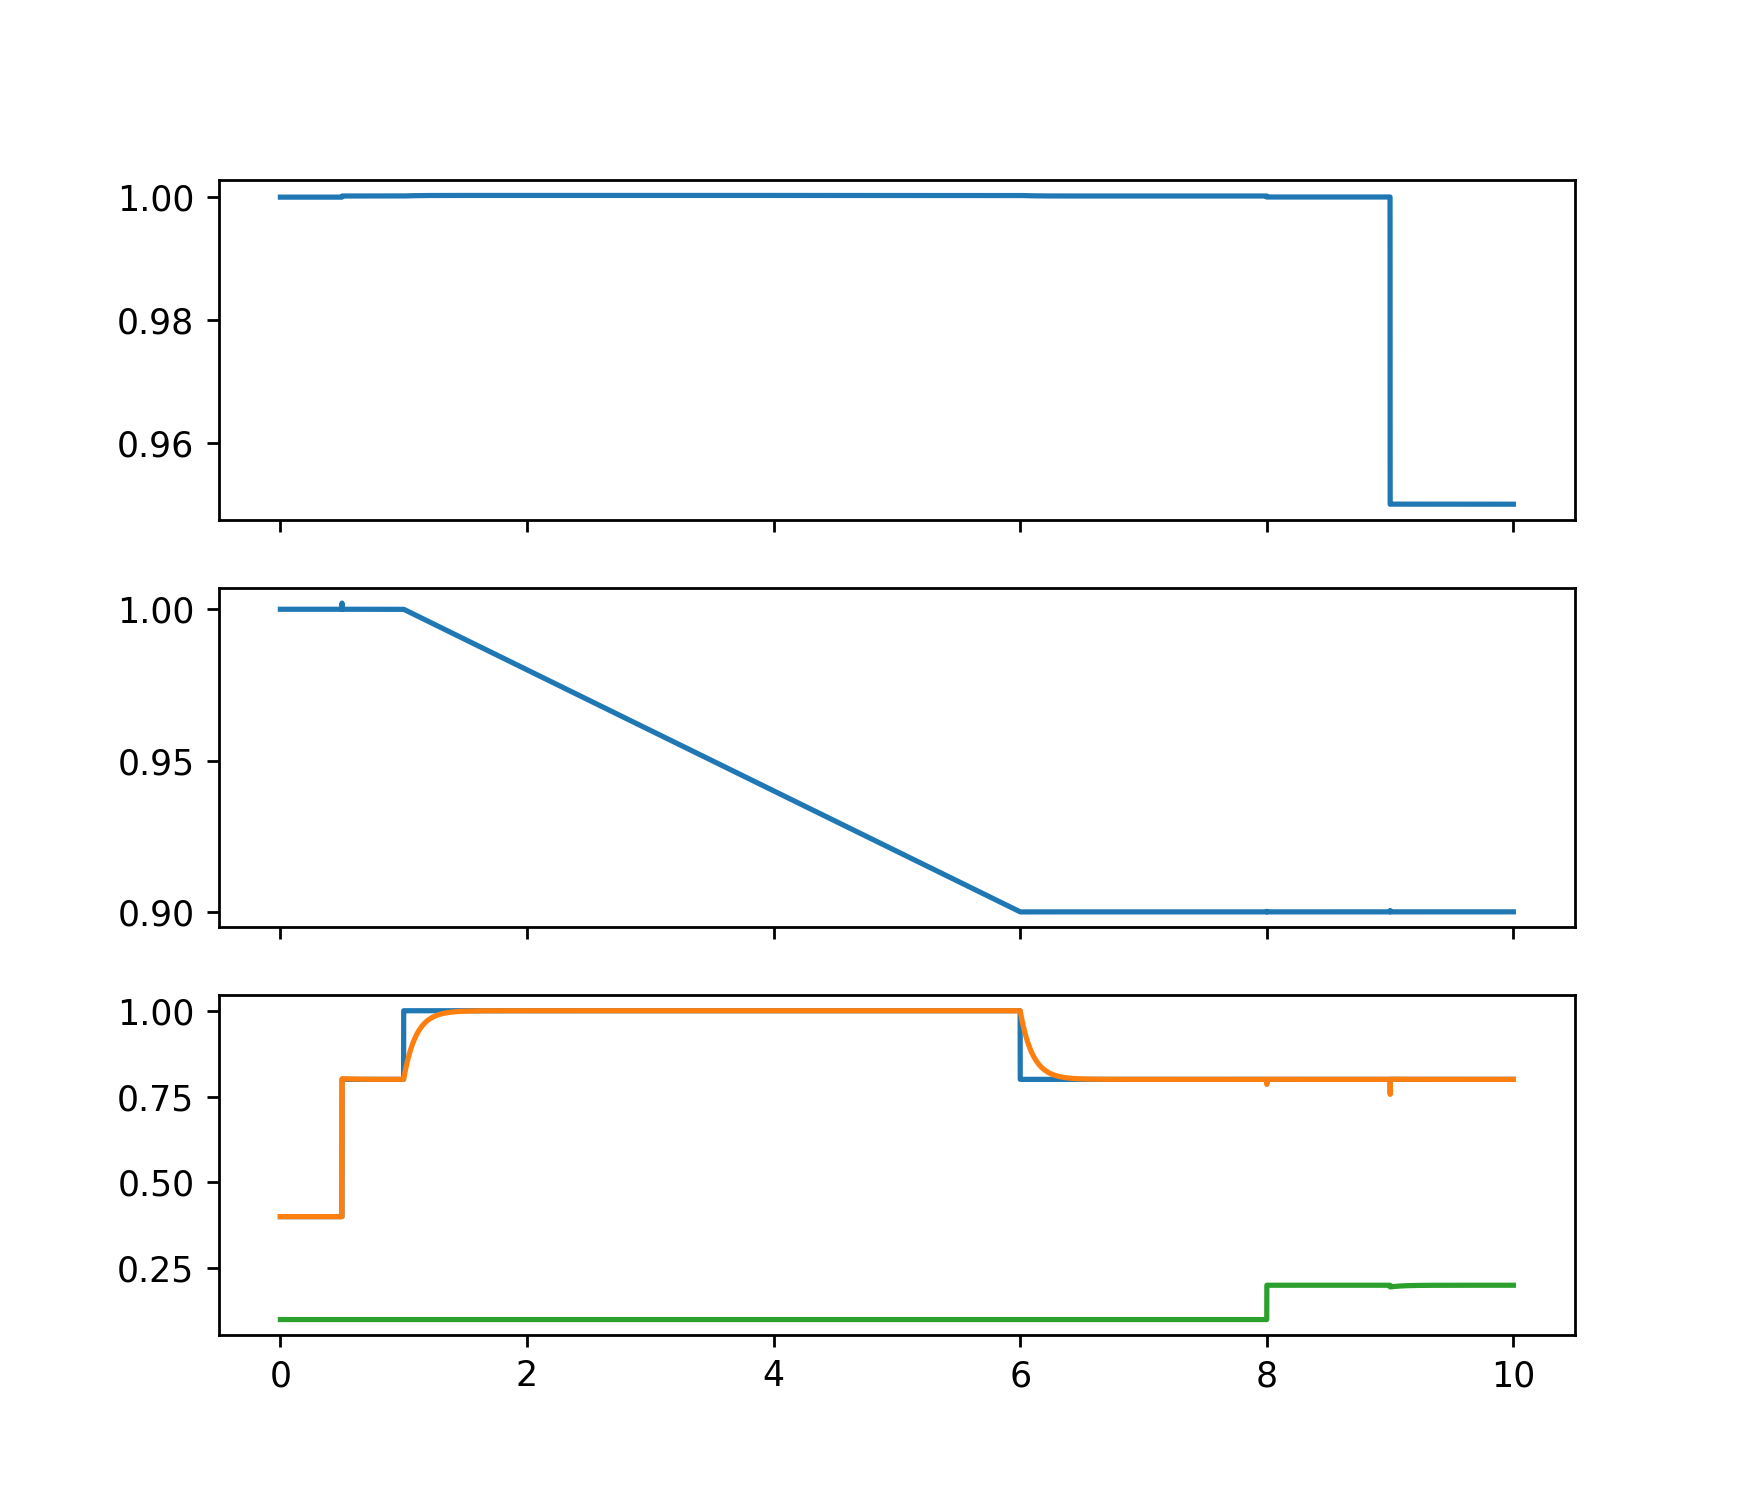

In [164]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 6), sharex = True)
axes[0].plot(T[:-1], (Y[:,12]**2+Y[:,13]**2)**0.5)


axes[1].plot(T[:-1], Y[:,0])
axes[2].plot(T[:-1], Y[:,2]+ Y[:,3])
axes[2].plot(T[:-1], Y[:,-2])
axes[2].plot(T[:-1], Y[:,-1])

In [155]:
phi_g = X[-1,3]
i_sr = Y[-1,6]
i_si = Y[-1,7]
v_sr = Y[-1,-5]
v_si = Y[-1,-6]
q_s = Y[-1,-1]
I_s = i_sr + 1j*i_si
V_s = v_sr + 1j*v_si
S_s = V_s*np.conj(I_s)

In [11]:
S_s

(0.7999999999997055+0.20000000000008875j)

In [12]:
q_s

0.20000000000008875